# Granite-TimeSeries-TTM   

TinyTimeMixers (TTMs) are compact pre-trained models for Multivariate Time-Series Forecasting, open-sourced by IBM Research. With less than 1 Million parameters, TTM introduces the notion of the first-ever "tiny" pre-trained models for Time-Series Forecasting. TTM outperforms several popular benchmarks demanding billions of parameters in zero-shot and few-shot forecasting and can easily be fine-tuned for multi-variate forecasts.

In [1]:
import pathlib

import numpy as np
import pandas as pd
from transformers import set_seed

from tsfm_public import TimeSeriesForecastingPipeline, TimeSeriesPreprocessor, TinyTimeMixerForPrediction
from tsfm_public.toolkit.time_series_preprocessor import get_datasets, prepare_data_splits
from tsfm_public.toolkit.visualization import plot_predictions


set_seed(42)

INFO:p-9545:t-8325308672:config.py:<module>:PyTorch version 2.3.0 available.


In [2]:
import tsfm_public


tsfm_public.__version__

'0.2.9.dev6+gc65d87f'

## Initial setup
1. Download energy_data.csv.zip and weather_data.csv.zip from https://www.kaggle.com/datasets/nicholasjhana/energy-consumption-generation-prices-and-weather
2. Place the downloaded files into a folder and update the data_path below

In [3]:
data_path = pathlib.Path("./data")

In [4]:
def compute_metric(actual, prediction):
    """Simple function to compute MSE"""
    a = np.asarray(actual.tolist())
    mask = ~np.any(np.isnan(a), axis=1)  # ~np.isnan(a)
    p = np.asarray(prediction.tolist())
    mse = np.mean(np.square(a[mask, :] - p[mask, :]))
    return {"mean_squared_error": mse, "root_mean_squared_error": np.sqrt(mse)}

## Load and prepare data

In [5]:
# Download energy_data.csv.zip from https://www.kaggle.com/datasets/nicholasjhana/energy-consumption-generation-prices-and-weather

dataset_path = data_path / "energy_dataset.csv.zip"
timestamp_column = "time"

id_columns = []
control_columns = []

target_columns = ["total load actual"]

context_length = 512
prediction_length = 96

data = pd.read_csv(
    dataset_path,
    parse_dates=[timestamp_column],
)

data = data.ffill()

data.head()

,time,generation biomass,generation fossil brown coal/lignite,generation fossil coal-derived gas,generation fossil gas,generation fossil hard coal,generation fossil oil,generation fossil oil shale,generation fossil peat,generation geothermal,...,generation waste,generation wind offshore,generation wind onshore,forecast solar day ahead,forecast wind offshore eday ahead,forecast wind onshore day ahead,total load forecast,total load actual,price day ahead,price actual
0,2015-01-01 00:00:00+01:00,447.0,329.0,0.0,4844.0,4821.0,162.0,0.0,0.0,0.0,...,196.0,0.0,6378.0,17.0,NaN,6436.0,26118.0,25385.0,50.10,65.41
1,2015-01-01 01:00:00+01:00,449.0,328.0,0.0,5196.0,4755.0,158.0,0.0,0.0,0.0,...,195.0,0.0,5890.0,16.0,NaN,5856.0,24934.0,24382.0,48.10,64.92
2,2015-01-01 02:00:00+01:00,448.0,323.0,0.0,4857.0,4581.0,157.0,0.0,0.0,0.0,...,196.0,0.0,5461.0,8.0,NaN,5454.0,23515.0,22734.0,47.33,64.48
3,2015-01-01 03:00:00+01:00,438.0,254.0,0.0,4314.0,4131.0,160.0,0.0,0.0,0.0,...,191.0,0.0,5238.0,2.0,NaN,5151.0,22642.0,21286.0,42.27,59.32
4,2015-01-01 04:00:00+01:00,428.0,187.0,0.0,4130.0,3840.0,156.0,0.0,0.0,0.0,...,189.0,0.0,4935.0,9.0,NaN,4861.0,21785.0,20264.0,38.41,56.04


## Create a TimeSeriesPreprocessor and prepare datasets

In [6]:
split_params = {"train": [0, 0.6], "valid": [0.6, 0.8], "test": [0.8, 1.0]}

params = {
    "timestamp_column": timestamp_column,
    "id_columns": id_columns,
    "target_columns": target_columns,
    "control_columns": control_columns,
    "context_length": 512,
    "prediction_length": 96,
}

tsp = TimeSeriesPreprocessor(
    **params,
    scaling=True,
    encode_categorical=False,
    scaler_type="standard",
)

train_data, valid_data, test_data = prepare_data_splits(
    data,
    id_columns=params["id_columns"],
    context_length=params["context_length"],
    split_config=split_params,
)

dset_train, dset_valid, dset_test = get_datasets(tsp, data, split_config=split_params)

## Load pretrained Granite-TimeSeries-TTM model (zero-shot)
The **TTM** model supports huggingface model interface, allowing easy API for loading the saved models.

In [7]:
zeroshot_model = TinyTimeMixerForPrediction.from_pretrained(
    "ibm-granite/granite-timeseries-ttm-v1",
    num_input_channels=tsp.num_input_channels,
    prediction_channel_indices=tsp.prediction_channel_indices,
)
model_parameters = sum(p.numel() for p in zeroshot_model.parameters() if p.requires_grad)
print("TTM Model parameters:", model_parameters)

TTM Model parameters: 805280


### Create a time series forecasting pipeline and evaluate performance

In [8]:
pipeline = TimeSeriesForecastingPipeline(
    zeroshot_model,
    timestamp_column=timestamp_column,
    id_columns=id_columns,
    target_columns=target_columns,
    control_columns=control_columns,
    batch_size=2000,
    feature_extractor=tsp,
)
zeroshot_forecast = pipeline(tsp.preprocess(test_data), inverse_scale_outputs=True)
zeroshot_forecast.head()

,time,total load actual_prediction,total load actual
0,2018-03-14 18:00:00+01:00,"[34301.32638747344, 34410.1279593795, 33894.03...","[35043.99973664599, 36229.999787301436, 35065...."
1,2018-03-14 19:00:00+01:00,"[35315.78704947306, 34552.1894837591, 32776.58...","[36229.999787301436, 35065.000150100284, 32327..."
2,2018-03-14 20:00:00+01:00,"[35010.7386956451, 32997.36807303803, 30518.40...","[35065.000150100284, 32327.999963904855, 29527..."
3,2018-03-14 21:00:00+01:00,"[32900.67038074348, 30506.35288397865, 28315.7...","[32327.999963904855, 29527.999966038646, 27513..."
4,2018-03-14 22:00:00+01:00,"[29735.098753113165, 27862.558666544886, 26264...","[29527.999966038646, 27513.00002212207, 25726...."


In [9]:
compute_metric(zeroshot_forecast["total load actual"], zeroshot_forecast["total load actual_prediction"])

{'mean_squared_error': 8531248.187481044,
 'root_mean_squared_error': 2920.830051112362}

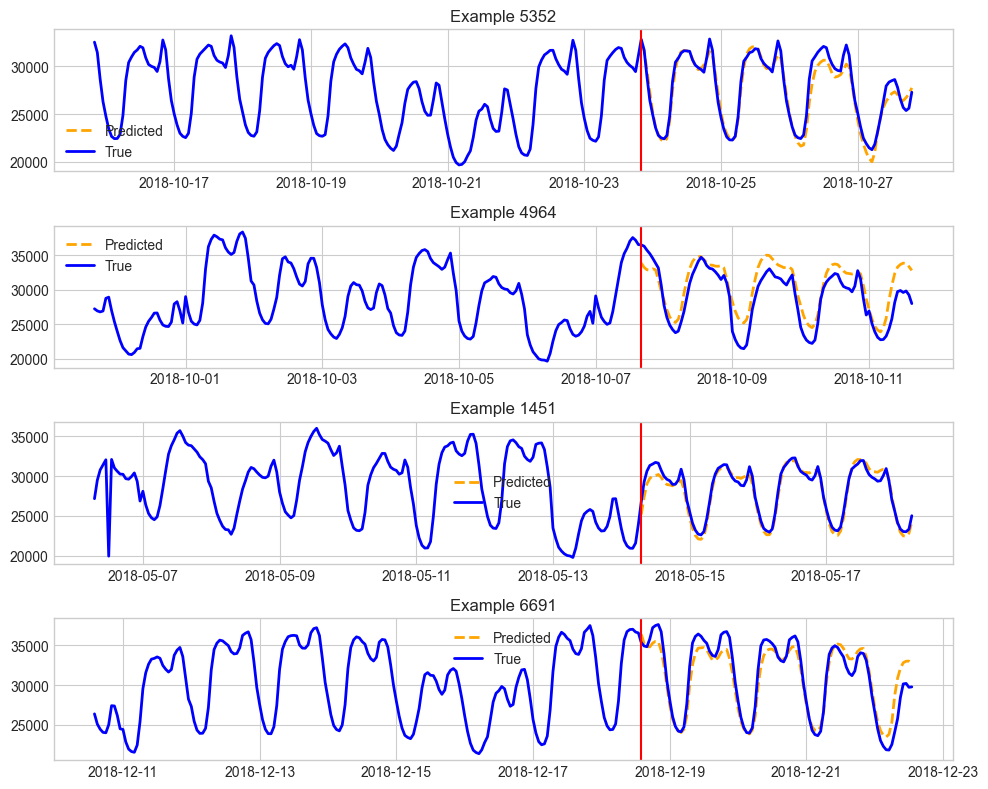

In [10]:
plot_predictions(
    test_df=test_data,
    predictions_df=zeroshot_forecast,
    timestamp_column=timestamp_column,
    freq=tsp.freq,
    plot_dir=None,
    plot_prefix="Test",
    channel="total load actual",
    plot_context=2 * prediction_length,
    indices=[5352, 4964, 1451, 6691],
    num_plots=4,
)

## Useful links

TinyTimeMixer paper: https://arxiv.org/abs/2401.03955  

Granite-TimeSeries-TTM model: https://huggingface.co/ibm-granite/granite-timeseries-ttm-v1  

Publicly available tools for working with our models: https://github.com/ibm-granite/granite-tsfm

© 2024 IBM Corporation